In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 62.7 MB/s eta 0:00:00


In [ ]:
import os
import tarfile
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import to_pil_image
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

# Initialize Weights & Biases logger
wandb.login()
wandb_logger = WandbLogger(project='DSAI544-Assignment-3', log_model=True)

# Check if GPU is available
if not torch.cuda.is_available():
    raise RuntimeError("GPU is not available. Please make sure to use the GPU partition.")

# Dataset preparation
imagenette_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'
imagenette_path = './imagenette2-160'
if not os.path.exists(imagenette_path):
    print("Downloading Imagenette dataset...")
    response = requests.get(imagenette_url, stream=True)
    with open('imagenette2-160.tgz', 'wb') as f:
        f.write(response.content)
    print("Extracting Imagenette dataset...")
    with tarfile.open('imagenette2-160.tgz', 'r:gz') as tar:
        tar.extractall()

# Define dataset transformations
imagenette_dataset = datasets.ImageFolder(
    root=imagenette_path,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# Split dataset into training and validation sets
train_size = int(0.8 * len(imagenette_dataset))
val_size = len(imagenette_dataset) - train_size
train_dataset, val_dataset = random_split(imagenette_dataset, [train_size, val_size])

# Data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Data augmentation transformations for SimCLR
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the contrastive loss function used for SimCLR
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        z = torch.cat((z_i, z_j), dim=0)
        sim_matrix = torch.matmul(z, z.T) / self.temperature
        sim_matrix_exp = torch.exp(sim_matrix)

        # Mask out the diagonal (self-similarity)
        mask = torch.eye(batch_size * 2, device=z.device).bool()
        sim_matrix_exp = sim_matrix_exp.masked_fill(mask, 0)

        # Calculate positive pair similarities
        pos_sim = torch.exp(torch.sum(z_i * z_j, dim=-1) / self.temperature)
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

        # Calculate loss
        denominator = sim_matrix_exp.sum(dim=-1).clamp(min=1e-8)
        loss = -torch.log(pos_sim / denominator)
        return loss.mean()

# Define the SimCLR model using PyTorch Lightning
class SimCLRLightning(pl.LightningModule):
    def __init__(self, base_model, projection_dim=128, temperature=0.5):
        super(SimCLRLightning, self).__init__()
        self.save_hyperparameters(ignore=['base_model'])
        self.base_model = base_model
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        self.temperature = temperature
        self.criterion = ContrastiveLoss(temperature)

    def forward(self, x):
        features = self.base_model(x)
        projections = self.projection_head(features)
        projections = nn.functional.normalize(projections, dim=1)
        return projections

    def training_step(self, batch, batch_idx):
        images, _ = batch
        images_aug = torch.stack([transform_aug(to_pil_image(image.cpu())) for image in images]).to(self.device)

        z_i = self(images)
        z_j = self(images_aug)

        loss = self.criterion(z_i, z_j)
        self.log('pretrain_train_loss', loss, prog_bar=True)  # Pre-training loss log
        return loss

    def validation_step(self, batch, batch_idx):
        images, _ = batch
        images_aug = torch.stack([transform_aug(to_pil_image(image.cpu())) for image in images]).to(self.device)

        z_i = self(images)
        z_j = self(images_aug)

        val_loss = self.criterion(z_i, z_j)
        self.log('pretrain_val_loss', val_loss, prog_bar=True)  # Pre-training validation loss log

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

# Fine-tuning on CIFAR-10 with PyTorch Lightning
class CIFAR10Lightning(pl.LightningModule):
    def __init__(self, pretrained_model, num_classes=10):
        super(CIFAR10Lightning, self).__init__()
        self.save_hyperparameters()
        self.model = pretrained_model
        self.model.fc = nn.Linear(512, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Fine-tuning training loss log
        self.log('finetune_train_loss', loss, prog_bar=True)

        # Accuracy log
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('finetune_train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        # Fine-tuning validation loss log
        self.log('finetune_val_loss', loss, prog_bar=True)

        # Validation accuracy log
        self.log('finetune_val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Pre-training with SimCLR
base_model = models.resnet18(weights=None)
base_model.fc = nn.Identity()
simclr_model = SimCLRLightning(base_model=base_model)
trainer = pl.Trainer(
    max_epochs=10,
    logger=wandb_logger,
    accelerator='gpu',
    devices=1
)
trainer.fit(simclr_model, train_loader, val_loader)

# Fine-tuning on CIFAR-10
cifar10_dataset = datasets.CIFAR10(
    root='./cifar10',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])
)

cifar10_train_size = int(0.8 * len(cifar10_dataset))
cifar10_val_size = len(cifar10_dataset) - cifar10_train_size
cifar10_train_dataset, cifar10_val_dataset = random_split(cifar10_dataset, [cifar10_train_size, cifar10_val_size])

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=32, shuffle=True)
cifar10_val_loader = DataLoader(cifar10_val_dataset, batch_size=32, shuffle=False)

# Initialize CIFAR-10 fine-tuning model
cifar10_model = CIFAR10Lightning(pretrained_model=simclr_model.base_model)
trainer = pl.Trainer(
    max_epochs=10,
    logger=wandb_logger,
    accelerator='gpu',
    devices=1
)

trainer.fit(cifar10_model, cifar10_train_loader, cifar10_val_loader)
torch.save(cifar10_model.state_dict(), 'fine_tuned_cifar10_model.pth')
print("Model saved successfully.")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type            | Params | Mode 
------------------------------------------------------------
0 | base_model      | ResNet          | 11.2 M | train
1 | projection_head | Sequential      | 164 K  | train
2 | criterion       | ContrastiveLoss | 0      | train
---

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Model saved successfully.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Files already downloaded and verified
Loading the fine-tuned model...


<ipython-input-9-74dfa7c83bea>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load model weights


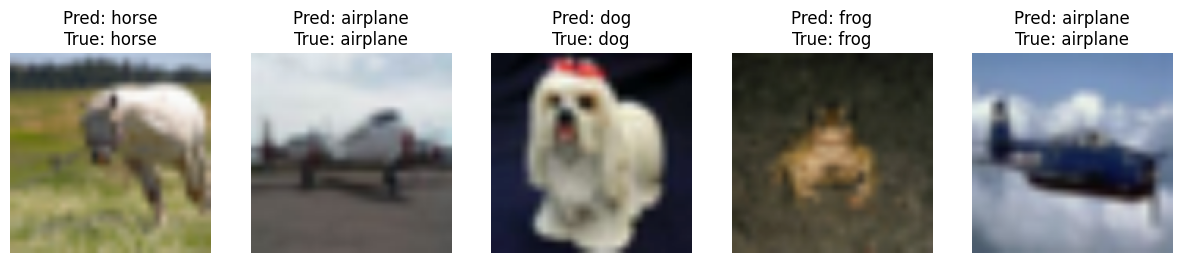

In [ ]:
import os
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import wandb

# W&B Run başlat
wandb.login()  # Ensure you are logged in with your WandB account
wandb.init(project='CIFAR10-Test', name='Test-Predictions')

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define transformations for validation set
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Load CIFAR-10 validation dataset
cifar10_val_dataset = CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
cifar10_val_loader = DataLoader(cifar10_val_dataset, batch_size=5, shuffle=True)

# Define the model structure
class CIFAR10Lightning(torch.nn.Module):
    def __init__(self, pretrained_model, num_classes=10):
        super(CIFAR10Lightning, self).__init__()
        self.model = pretrained_model
        self.model.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)

# Load the fine-tuned model from the working directory
print("Loading the fine-tuned model...")
model_path = "fine_tuned_cifar10_model.pth"  # Ensure this file is uploaded to Colab's working directory
model = CIFAR10Lightning(pretrained_model=models.resnet18(weights=None))
model.load_state_dict(torch.load(model_path))  # Load model weights
model.eval()  # Set model to evaluation mode

# Perform prediction on validation dataset
data_iter = iter(cifar10_val_loader)
images, labels = next(data_iter)

with torch.no_grad():
    outputs = model(images)  # Get model outputs
    predictions = outputs.argmax(dim=1)  # Get predicted class indices

# Tahminler ve görselleri W&B'ye logla
wandb_table = wandb.Table(columns=["Image", "Prediction", "True Label"])

fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Display 5 images
for idx in range(5):
    img = images[idx].permute(1, 2, 0).cpu().numpy()
    img = img * [0.2023, 0.1994, 0.2010] + [0.4914, 0.4822, 0.4465]  # Denormalize
    img = (img * 255).astype('uint8')

    # Görsel ve tahminleri tabloya ekle
    wandb_table.add_data(
        wandb.Image(img),  # Görsel
        CIFAR10_CLASSES[predictions[idx]],  # Tahmin
        CIFAR10_CLASSES[labels[idx]]  # Gerçek
    )

    # Görselleştirme için Matplotlib
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Pred: {CIFAR10_CLASSES[predictions[idx]]}\nTrue: {CIFAR10_CLASSES[labels[idx]]}")

# W&B'ye tabloyu logla
wandb.log({"Test Predictions": wandb_table})

# Matplotlib grafiğini W&B'ye logla
wandb.log({"Test Predictions Plot": wandb.Image(fig)})

plt.show()